# 02. Process Survey Data
The data from the previous step is in many different tables. This notebook cleans up and concatenates all of these data. 

We also add environmental data to the each core site, including bottom water oxygen and sedimentation rate. These are source from gridded datasets with global coverage using models. We also add data for carbonate content at the top of the core or the Last Glacial Maximum by taking regional averages based on data from a compilation by Catubig et al.

This notebook exports a table of all of the cores from the IODP program in contact with the sediment water interface, including their metadata, links to core photos, environmental variables. This product makes it easy to look at each photo and give it a label related to the appearance of diagenesis in the core section. 

## Setup
### Import Modules

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import netCDF4
from IPython.display import clear_output
import rioxarray
import geopandas as gpd

### Set Paths

In [142]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
survey_data='/Users/danielbabin/GitHub/Green_Bands/Data/Survey/'
environmental_data='/Users/danielbabin/GitHub/Green_Bands/Data/Environmental/'
shapefile_path='/Users/danielbabin/GitHub/Green_Bands/Data/Shapefiles/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

## Clean and Join Tables
### Load Sites Metadata

In [143]:
sites=pd.read_csv(survey_data+'all.DSDP.ODP.IODP.sites.csv')
sites['era']=None
sites.loc[sites['leg']<=96,'era']='DSDP'
sites.loc[sites['leg'].between(99,210),'era']='ODP'
id_beginning_IODP=sites.loc[sites['expedition']=='301'].index[0]
id_end_IODP=sites.loc[sites['expedition']=='312'].index[-1]
sites.loc[id_beginning_IODP:id_end_IODP,'era']='Early IODP'
sites.loc[id_end_IODP+1:3964,'era']='Modern IODP'

### Load results from pull in previous notebook

In [144]:
dsdp_sum=pd.read_csv(survey_data+'dsdp_site_summaries.csv')
odp_sum=pd.read_csv(survey_data+'odp_site_summaries.csv').dropna(how='all',axis=1)
early_iodp_sum=pd.read_csv(survey_data+'early_iodp_site_summaries.csv').dropna(how='all',axis=1)
mod_iodp_sum=pd.read_csv(survey_data+'modern_iodp_site_summaries.csv')

In [145]:
goal_colnames=['Era','Leg/Exp','Site','Hole','Latitude','Longitude','Water depth (m)']

## Make uniform column names
The different IODP eras have slightly different ways of referring to expeditions (also called legs). Early eras latitude and longitude are reported in degree values rather than decimal, and I prefer decimal. Also the columns for water depth and site have some stray spaces on them that need to be stripped.
### DSDP

In [146]:
dsdp_sum=dsdp_sum.rename(columns={'leg':'Leg/Exp','site':'Site','hole':'Hole',
                          'latitude':'Latitude','longitude':'Longitude',
                          'water depth(m)':'Water depth (m)'})
dsdp_sum['Era']='DSDP'

### ODP
#### Convert lat-lon to decimal degress

In [147]:
## lat
lat=odp_sum['Latitude   '].str.split('&deg;',expand=True)
lat['degrees']=lat[0].astype(float)
lat['minutes']=lat[1].str[:-2].astype(float)
lat['N/S']=lat[1].str[-1:]
lat['sign']=None
lat.loc[lat['N/S']=='N','sign']=1
lat.loc[lat['N/S']=='S','sign']=-1
lat['decimal']=(lat['degrees']+lat['minutes']/60)*lat['sign']
odp_sum['latitude']=lat['decimal']
## lon
lon=odp_sum['Longitude   '].str.split('&deg;',expand=True)
lon['degrees']=lon[0].astype(float)
lon['minutes']=lon[1].str[:-2].astype(float)
lon['E/W']=lon[1].str[-1:]
lon['sign']=None
lon.loc[lon['E/W']=='E','sign']=1
lon.loc[lon['E/W']=='W','sign']=-1
lon['decimal']=(lon['degrees']+lon['minutes']/60)*lon['sign']
odp_sum['longitude']=lon['decimal']

#### Strip string for site / hole

In [148]:
odp_sum['site']=odp_sum['Site/Hole   '].str.strip().str[:-1]
odp_sum['hole']=odp_sum['Site/Hole   '].str.strip().str[-1:]

#### Find leg
There are multiple sites collected on each leg, and the table so far just has sites.

In [149]:
odp_sum['leg']=None
for i in odp_sum.index:
    site=odp_sum.loc[i,'site']
    idx=sites[sites['site']==site].index[0]
    odp_sum.loc[i,'leg']=sites.loc[idx,'leg'].astype(int).astype(str)

#### Rename columns

In [150]:
odp_sum=odp_sum.rename(columns={'leg':'Leg/Exp','site':'Site','hole':'Hole',
                        'latitude':'Latitude','longitude':'Longitude',
                        'Water Depth (mbsl)':'Water depth (m)'})
odp_sum['Era']='ODP'

### Early IODP

#### Strip string for site / hole

In [151]:
early_iodp_sum['site']=early_iodp_sum['Site/Hole   '].str.strip().str[:-1]
early_iodp_sum['hole']=early_iodp_sum['Site/Hole   '].str.strip().str[-1:]

In [152]:
early_iodp_sum['>1300']=early_iodp_sum['site'].astype(int)>=1300
early_iodp_sum.loc[early_iodp_sum['>1300'],'site']='U'+early_iodp_sum.loc[early_iodp_sum['>1300'],'site']

#### Find leg
There are multiple sites collected on each leg, and the table so far just has sites.

In [153]:
early_iodp_sum['leg']=None
for i in early_iodp_sum.index:
    site=early_iodp_sum.loc[i,'site']
    idx=sites[sites['site']==site].index[0]
    if sites.loc[idx,'leg'].astype(int).astype(str) == '0':
        early_iodp_sum.loc[i,'leg']=int(sites.loc[idx,'expedition'])
    else:
        early_iodp_sum.loc[i,'leg']=sites.loc[idx,'leg'].astype(int).astype(str)

#### Convert lat-lon to decimal degrees

In [154]:
## lat
lat=early_iodp_sum['Latitude   '].str.split('&deg;',expand=True)
lat['degrees']=lat[0].astype(float)
lat['minutes']=lat[1].str[:-2].astype(float)
lat['N/S']=lat[1].str[-1:]
lat['sign']=None
lat.loc[lat['N/S']=='N','sign']=1
lat.loc[lat['N/S']=='S','sign']=-1
lat['decimal']=(lat['degrees']+lat['minutes']/60)*lat['sign']
early_iodp_sum['latitude']=lat['decimal']
## lon
lon=early_iodp_sum['Longitude   '].str.split('&deg;',expand=True)
lon['degrees']=lon[0].astype(float)
lon['minutes']=lon[1].str[:-2].astype(float)
lon['E/W']=lon[1].str[-1:]
lon['sign']=None
lon.loc[lon['E/W']=='E','sign']=1
lon.loc[lon['E/W']=='W','sign']=-1
lon['decimal']=(lon['degrees']+lon['minutes']/60)*lon['sign']
early_iodp_sum['longitude']=lon['decimal']

#### Rename columns

In [155]:
early_iodp_sum=early_iodp_sum.rename(columns={'leg':'Leg/Exp','site':'Site','hole':'Hole',
                                      'latitude':'Latitude','longitude':'Longitude',
                                      'Water Depth (mbsl)':'Water depth (m)'})

#### Strip string for water depth

In [156]:
early_iodp_sum['Water depth (m)']=early_iodp_sum['Water depth (m)'].str.strip()
early_iodp_sum['Water depth (m)']=pd.to_numeric(early_iodp_sum['Water depth (m)'])
early_iodp_sum['Era']='Early IODP'

### Modern IODP

In [157]:
mod_iodp_sum=mod_iodp_sum.rename(columns={'Latitude':'latitude','Longitude':'longitude'})

In [158]:
## lat
mod_iodp_sum['latitude']=mod_iodp_sum['latitude'].replace({' ':'  '})
lat=mod_iodp_sum['latitude'].str.split(' ',expand=True)
lat['degrees']=lat[0].str.split('°',expand=True)[0].astype(float)
lat['minutes']=lat[1].str.split("'",expand=True)[0]
lat['minutes']=pd.to_numeric(lat['minutes'])
lat['N/S']=lat[2]
lat['sign']=None
lat.loc[lat['N/S']=='N','sign']=1
lat.loc[lat['N/S']=='S','sign']=-1
lat['decimal']=(lat['degrees']+lat['minutes']/60)*lat['sign']
mod_iodp_sum['Latitude']=lat['decimal']
## lon
mod_iodp_sum['longitude']=mod_iodp_sum['longitude'].replace({' ':'  '})
lon=mod_iodp_sum['longitude'].str.split(' ',expand=True)
lon['degrees']=lon[0].str.split('°',expand=True)[0].astype(float)
lon['minutes']=lon[1].str.split("'",expand=True)[0]
lon['minutes']=pd.to_numeric(lat['minutes'])
lon['E/W']=lon[2]
lon['sign']=None
lon.loc[lon['E/W']=='E','sign']=1
lon.loc[lon['E/W']=='W','sign']=-1
lon['decimal']=(lon['degrees']+lon['minutes']/60)*lon['sign']
mod_iodp_sum['Longitude']=lon['decimal']

In [159]:
mod_iodp_sum=mod_iodp_sum.rename(columns={'Exp':'Leg/Exp','Site':'Site','Hole':'Hole'})
mod_iodp_sum['Era']='Modern IODP'

## Combine metadata for site locations from different eras into one table

In [160]:
every_core=pd.concat([dsdp_sum[goal_colnames],odp_sum[goal_colnames],
                      early_iodp_sum[goal_colnames],mod_iodp_sum[goal_colnames]],ignore_index=True)

## Add environmental variables for each site
### Oxygen
This is sourced from the World Ocean Atlas

In [161]:
woa=xr.open_dataset(environmental_data+'woa18_all_o00_01.nc',decode_times=False)
glodap=xr.open_dataset(environmental_data+'bwo_glodap.nc',decode_times=False)
seiter=xr.open_dataset(environmental_data+'oxygen_bottomwater_seiteretal_2005.nc',decode_times=False)

In [162]:
every_core['BWO Glodap']=np.nan
every_core['BWO WOA']=np.nan
every_core['BWO Seiter']=np.nan
for i,site in enumerate(every_core.index):
    clear_output(wait=True)
    lon=every_core.iloc[i].Longitude
    lat=every_core.iloc[i].Latitude
    depth=every_core.iloc[i]['Water depth (m)']
    woa_bottom=(woa.sel(lon=slice(lon-2,lon+2))
                .sel(lat=slice(lat-2,lat+2))
                .sel(depth=slice(depth-100,depth+300)).mean()['o_an'])
    glodap_bottom=(glodap.sel(lon=slice(lon-2,lon+2))
                   .sel(lat=slice(lat-2,lat+2)).mean()['oxygen'])
    seiter_bottom=(seiter.sel(lon=slice(lon-2,lon+2))
                   .sel(lat=slice(lat-2,lat+2)).mean()['z'])
    every_core.loc[site,'BWO Glodap']=glodap_bottom.values
    every_core.loc[site,'BWO WOA']=woa_bottom.values
    every_core.loc[site,'BWO Seiter']=seiter_bottom.values
    print(i,'/',len(every_core))

3811 / 3812


### Mass Accumulation Rate
This is sourced from [Restreppo et al. 2021, "Machine-learning predicted logarithmic values of marine mass accumulation rates on the seafloor](http://get.iedadata.org/doi/329906)

In [163]:
mar=xr.open_dataset(environmental_data+'Log10_prediction_5m.nc',decode_times=False)

In [164]:
every_core['MAR Restreppo']=np.nan
for i,site in enumerate(every_core.index):
    lon=every_core.iloc[i].Longitude
    lat=every_core.iloc[i].Latitude
    MAR=10**(mar.sel(lon=slice(lon-1,lon+1)).sel(lat=slice(lat-1,lat+1))).mean()['z']
    every_core.loc[site,'MAR Restreppo']=MAR.values

### Sed Rate
This is sourced from [Dutkiewicz et al. 2017, "Predicting Sediment Thickness on Vanished Ocean Crust Since 200 Ma."](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2017GC007258)

In [165]:
sr=xr.open_dataset(environmental_data+'average_sedimentation_rate_from_decomp_sed_thick_cm_per_ka.nc',decode_times=False)

In [166]:
every_core['SR Dutkiewicz']=np.nan
for i,site in enumerate(every_core.index):
    lon=every_core.iloc[i].Longitude
    lat=every_core.iloc[i].Latitude
    every_core.loc[site,'SR Dutkiewicz']=sr.sel(lon=slice(lon-1,lon+1)).sel(lat=slice(lat-1,lat+1)).mean()['z']

### Productivity

In [167]:
productivity=xr.open_dataset(environmental_data+'SeaWiFS_summer_productivity_12year_stack.nc',decode_times=False)

In [168]:
every_core['Productivity Lee']=np.nan ### mgC/m2/day
for i,site in enumerate(every_core.index):
    lon=every_core.iloc[i].Longitude
    lat=every_core.iloc[i].Latitude
    every_core.loc[site,'Productivity Lee']=productivity.sel(lon=slice(lon-1,lon+1)).sel(lat=slice(lat-1,lat+1)).mean()['z']

### Calcium Carbonate Archer

In [169]:
archer=xr.open_dataset(environmental_data+'caco3_archer.nc',decode_times=False)

In [170]:
every_core['CaCO3 Archer']=np.nan ### mgC/m2/day
for i,site in enumerate(every_core.index):
    lon=every_core.iloc[i].Longitude
    lat=every_core.iloc[i].Latitude
    every_core.loc[site,'CaCO3 Archer']=archer.sel(Longitude=slice(lon-1,lon+1)).sel(Latitude=slice(lat-1,lat+1)).mean()['CaCO3']

### Organic Carbon

In [171]:
oc=xr.open_dataset(environmental_data+'Lee_et_al_2019_DatasetS1.nc',decode_times=False)

In [172]:
every_core['OC Lee']=np.nan ### mgC/m2/day
for i,site in enumerate(every_core.index):
    lon=every_core.iloc[i].Longitude
    lat=every_core.iloc[i].Latitude
    every_core.loc[site,'OC Lee']=oc.sel(lon=slice(lon-1,lon+1)).sel(lat=slice(lat-1,lat+1)).mean()['z']

### Load CaCO3 data

In [173]:
lgmcaco3=pd.read_csv(survey_data+'Catubig_CaCO3_LGM.tab',sep='\t',header=507)
hcaco3=pd.read_csv(survey_data+'Catubig_CaCO3_Holocene.tab',sep='\t',header=411)

/Users/danielbabin/miniconda3/envs/geospatial/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/danielbabin/miniconda3/envs/geospatial/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


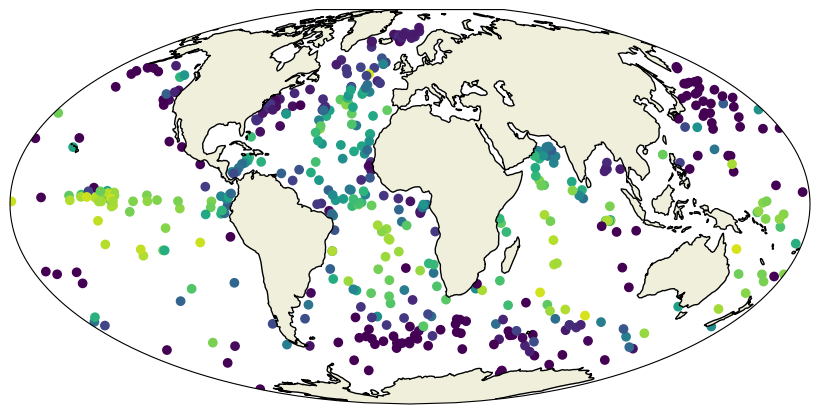

In [174]:
fig=plt.figure(figsize=(8,4))
proj=ccrs.Mollweide()
ax=fig.add_axes([0, 0, 1, 1],projection=proj)
ax.scatter(lgmcaco3['Longitude'],lgmcaco3['Latitude'],c=lgmcaco3['CaCO3 [%]'],transform=ccrs.Geodetic(),
           vmin=0,vmax=100)
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.COASTLINE,zorder=2)

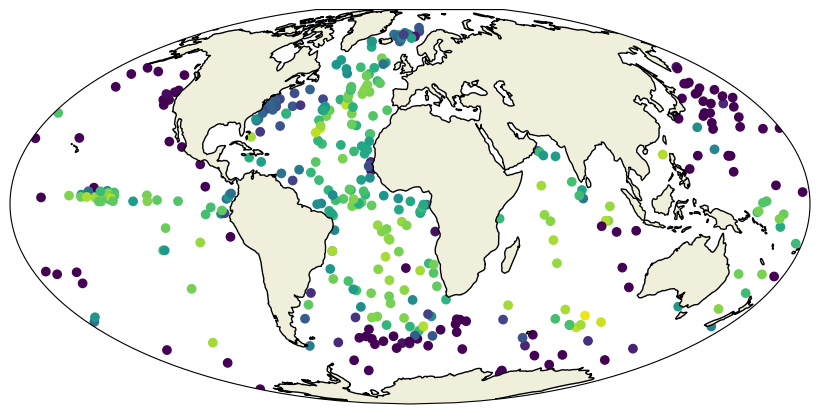

In [175]:
fig=plt.figure(figsize=(8,4))
proj=ccrs.Mollweide()
ax=fig.add_axes([0, 0, 1, 1],projection=proj)
ax.scatter(hcaco3['Longitude'],hcaco3['Latitude'],c=hcaco3['CaCO3 [%]'],transform=ccrs.Geodetic(),
           vmin=0,vmax=100)
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.COASTLINE,zorder=2)

### Load Longhurst Zone
We use the shapes of the longhurst biogeochemical zones to create regional averages for CaCO3 percent in seafloor sediments at present and during the Last Glacial Maximum

In [176]:
zones = gpd.read_file(shapefile_path+"/Longhurst_Zones/Longhurst_world_v4_2010.shp")

In [177]:
from shapely.geometry import Point

### Find Longhurst Zone of each IODP Site

In [178]:
# Convert the lat/lon columns of the scatter data to a list of shapely Point objects
points = [Point(xy) for xy in zip(every_core['Longitude'], every_core['Latitude'])]

# Create a new column in the scatter data for the zone value
every_core['ProvCode'] = None

# Loop over each point in the scatter data
for i, point in enumerate(points):
    # Loop over each polygon in the zones GeoDataFrame
    for j, polygon in zones.iterrows():
        # Check if the point is contained in the polygon
        if polygon['geometry'].contains(point):
            # If it is, assign the zone value to the corresponding row in the scatter data
            every_core.loc[i, 'ProvCode'] = polygon['ProvCode']
            break  # No need to check the other polygons

### Take regional averages of CaCO3 content during Holocene and LGM

In [179]:
# Load the scatter data
lgmcaco3=lgmcaco3.rename(columns={'CaCO3 [%]':'LGM CaCO3 (%)'})
hcaco3=hcaco3.rename(columns={'CaCO3 [%]':'Holocene CaCO3 (%)'})

lgm_caco3_gdf = gpd.GeoDataFrame(
    lgmcaco3, geometry=gpd.points_from_xy(lgmcaco3.Longitude, lgmcaco3.Latitude), crs="epsg:4326")
h_caco3_gdf = gpd.GeoDataFrame(
    hcaco3, geometry=gpd.points_from_xy(hcaco3.Longitude, hcaco3.Latitude), crs="epsg:4326")

# Spatial join scatter data to zones based on location
h_caco3_joined = gpd.sjoin(zones, h_caco3_gdf, how="left", op="contains")
lgm_caco3_joined = gpd.sjoin(zones, lgm_caco3_gdf, how="left", op="contains")

# Compute mean value for each zone
h_caco3_zone_means = h_caco3_joined.groupby("ProvCode")['Holocene CaCO3 (%)'].mean()
lgm_caco3_zone_means = lgm_caco3_joined.groupby("ProvCode")['LGM CaCO3 (%)'].mean()

# Join mean values back to zones
zones = zones.merge(h_caco3_zone_means, on="ProvCode", how="left")
zones = zones.merge(lgm_caco3_zone_means, on="ProvCode", how="left")

zones['Holocene-LGM CaCO3 (%)']=zones['Holocene CaCO3 (%)']-zones['LGM CaCO3 (%)']

/Users/danielbabin/miniconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/danielbabin/miniconda3/envs/geospatial/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


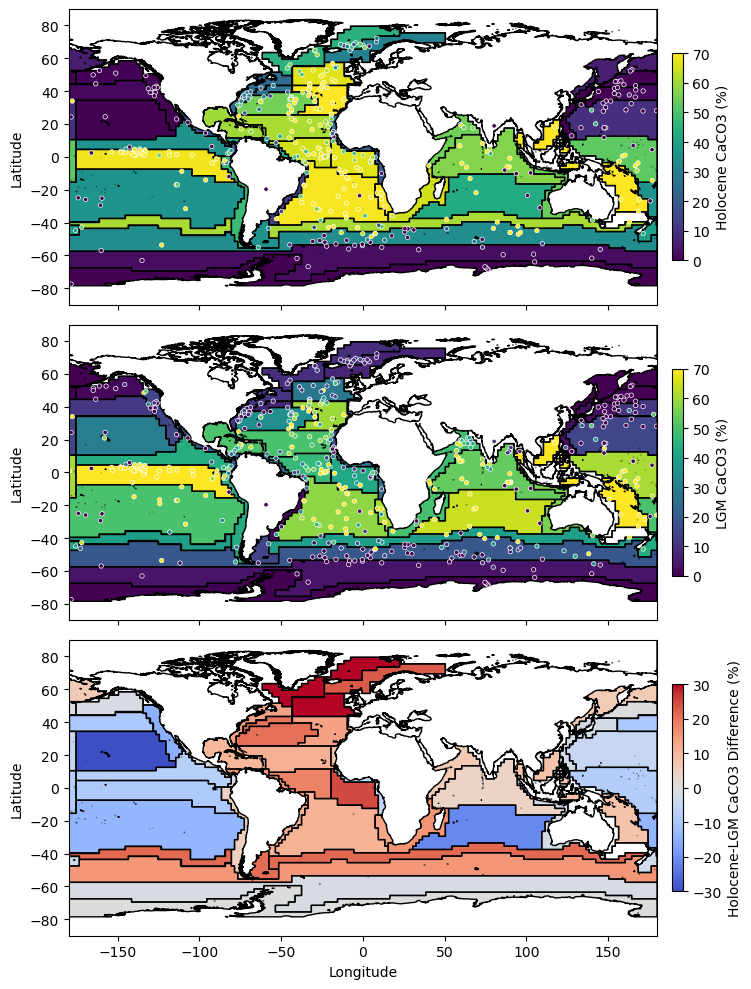

In [180]:
# Plot the zones with the mean values as the fill color
fig,axes = plt.subplots(nrows=3,figsize=(8,10),sharex=True)
ax=axes[0]
zones.plot(column='Holocene CaCO3 (%)',ax=ax,legend=True,vmin=0,vmax=70,
           legend_kwds={'shrink': 7/10,'pad':.02,'label':'Holocene CaCO3 (%)'})
zones.plot(ax=ax, color='none', edgecolor='black')
ax.scatter(hcaco3['Longitude'],hcaco3['Latitude'],c=hcaco3['Holocene CaCO3 (%)'],
           edgecolor='w',s=10,lw=.5,vmin=0,vmax=70)

ax=axes[1]
zones.plot(column='LGM CaCO3 (%)',cmap='viridis',ax=ax,legend=True,vmin=0,vmax=70,
           legend_kwds={'shrink': 7/10,'pad':.02,'label':'LGM CaCO3 (%)'})
zones.plot(ax=ax, color='none', edgecolor='black')
ax.scatter(lgmcaco3['Longitude'],lgmcaco3['Latitude'],c=lgmcaco3['LGM CaCO3 (%)'],
           edgecolor='w',s=10,lw=.5,vmin=0,vmax=70)

ax=axes[2]
zones.plot(column='Holocene-LGM CaCO3 (%)',cmap='coolwarm',legend=True,ax=ax,vmin=-30,vmax=30,
           legend_kwds={'shrink': 7/10,'pad':.02,'label':'Holocene-LGM CaCO3 Difference (%)'})
zones.plot(ax=ax, color='none', edgecolor='black')

for ax in axes:
    ax.set_xlim(-180,180)
    ax.set_ylim(-90,90)
    ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.tight_layout()

### Add CaCO3 data to summary table

In [181]:
every_core = every_core.merge(zones[['ProvCode', 'Holocene CaCO3 (%)', 'LGM CaCO3 (%)',
                                     'Holocene-LGM CaCO3 (%)']], on='ProvCode', how='left')

## Add links to core photos and filenames to summary table

### Create site code

In [182]:
every_core.loc[every_core['Hole'].isnull(),'Hole']='*'

In [183]:
every_core['Code']=(every_core['Leg/Exp'].astype(str)+'-'+
                    every_core['Site'].astype(str)+'-'+
                    every_core['Hole'].astype(str))

### DSDP Era Photos

In [184]:
dsdp_photos=pd.read_csv(survey_data+'dsdp_core_photo_links.csv')
dsdp_coretop_photos=dsdp_photos[dsdp_photos['Depth (mbsf)']==0].copy()

In [185]:
dsdp_coretop_photos['Code']=(dsdp_coretop_photos['Leg'].astype(str)+'-'+
                             dsdp_coretop_photos['Site'].astype(int).astype(str)+'-'+
                             dsdp_coretop_photos['H'].astype(str))

In [186]:
collist=['Code','Image Link','Filename']
dsdp_cols=pd.merge(every_core.reset_index(), dsdp_coretop_photos[collist], 
                   on='Code', how='left').drop_duplicates().set_index('index')[['Image Link','Filename']].dropna()

### ODP Era Photos

In [187]:
odp_photos=pd.read_csv(survey_data+'odp_core_photo_links.csv')
odp_photos['Depth (mbsf)']=pd.to_numeric(odp_photos['Depth (mbsf)'].str.strip())
odp_coretop_photos=odp_photos[odp_photos['Depth (mbsf)']==0].copy()
odp_coretop_photos=odp_coretop_photos[odp_coretop_photos['Filename'].str.endswith('.PDF')].copy()

In [188]:
odp_coretop_photos['Code']=(odp_coretop_photos['Leg'].astype(str)+'-'+
                             odp_coretop_photos['Site'].astype(int).astype(str)+'-'+
                             odp_coretop_photos['H'].astype(str))

In [189]:
collist=['Code','Image Link','Filename']
odp_cols=pd.merge(every_core.reset_index(), odp_coretop_photos[collist], 
                   on='Code', how='left').drop_duplicates().set_index('index')[['Image Link','Filename']].dropna(how='all',axis=0)

### Early IODP Era Photos

In [190]:
early_iodp_photos=pd.read_csv(survey_data+'early_iodp_core_photo_links.csv')
early_iodp_coretop_photos=early_iodp_photos[early_iodp_photos['Depth (mbsf)']==0].copy()
early_iodp_coretop_photos=early_iodp_coretop_photos[early_iodp_coretop_photos['Filename'].str.endswith('.PDF')].copy()

In [191]:
early_iodp_coretop_photos['Code']=(early_iodp_coretop_photos['Leg'].astype(str)+'-'+'U'+
                                   early_iodp_coretop_photos['Site'].astype(int).astype(str)+'-'+
                                   early_iodp_coretop_photos['H'].astype(str))

In [192]:
collist=['Code','Image Link','Filename']
early_iodp_cols=pd.merge(every_core.reset_index(), early_iodp_coretop_photos[collist], 
                         on='Code', how='left').drop_duplicates().set_index('index')[['Image Link','Filename']].dropna()

### Modern IODP Era Photos

In [193]:
modern_iodp_photos=pd.read_csv(survey_data+'modern_iodp_core_photo_links.csv')
mod_iodp_coretop_photos=modern_iodp_photos[modern_iodp_photos['Top depth CSF-A (m)']==0].copy()
mod_iodp_coretop_photos=mod_iodp_coretop_photos.rename(columns={'Image (PNG) link':'Image Link','Image filename':'Filename'})

In [194]:
mod_iodp_coretop_photos['Code']=(modern_iodp_photos['Exp'].astype(str)+'-'+
                                 modern_iodp_photos['Site'].astype(str)+'-'+
                                 modern_iodp_photos['Hole'].astype(str))

In [195]:
mod_iodp_cols=pd.merge(every_core.reset_index(), mod_iodp_coretop_photos[collist], 
                         on='Code', how='left').drop_duplicates().set_index('index')[['Image Link','Filename']].dropna()

### Join

In [196]:
for i,data in enumerate([dsdp_cols,odp_cols,early_iodp_cols,mod_iodp_cols]):
    columns=data.columns
    every_core.loc[data.index,['Image Link','Filename']]=data[columns]

## Export

In [197]:
every_core.to_csv(checkpoints_path+'core_survey.csv',index=False)